# (APERTAR O BOTÃO ACIMA PARA VER O CÓDIGO)

# Relatório Landmarks - Nicholas Richers

In [1]:
#bibliotecas utilizadas
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load libraries and set plot parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 12
import warnings
warnings.filterwarnings('ignore')

# Importação dos Dados:

Utilizando o mesmo dataset já preparado no relatório market basket:
* Haviam 18 filmes com Id duplicado, que foram removidos
* A alteração dos filmes do Id duplicado gerou 522 notas duplicadas (i.e mesmo usuario dando nota pro mesmo filme) (261 foram removidas)

In [3]:
#carrega os dados
from setup_database import setup_BD, setup_results, get_genre, fill_na

#carregando os datasets de ratings
original_ratings_100k = pd.read_csv('./ml-100k/u.data', header=None, delimiter="\t" )
original_ratings_1M = pd.read_csv('./ml-1m/ratings.dat', header=None, delimiter=":" )


#carregando os datasets de filmes
original_movies_100k = pd.read_csv('./ml-100k/u.item', header=None, sep='|' , encoding='latin-1')
original_movies_1M = pd.read_csv('./ml-1m/movies.dat', header=None, sep=';' , encoding='latin-1')


#obter os datasets limpos
rat_100k, mov_100k = setup_BD(original_ratings_100k, original_movies_100k)
rat_1M, mov_1M = setup_BD(original_ratings_1M, original_movies_1M)

## Análise Exploratória (Dataset 100k)

Através do __Gráfico Boxplot__ abaixo, temos algumas informções interessantes como a __média de 106 filmes assistidos por usuário__, com uma máximo de 737.

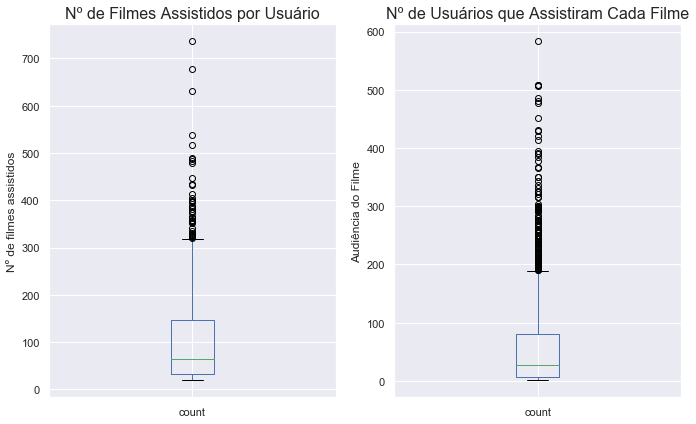

Descrição dos Filmes por Usuário


,count,mean,std,min,25%,50%,75%,max
count,943.0,105.718982,100.620656,19.0,33.0,64.0,147.5,736.0


In [4]:
#analise exploratoria
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
Users_Count_100k = rat_100k.groupby('User_Id').Rating.agg(['count'])
Users_Count_100k.boxplot()
plt.title("Nº de Filmes Assistidos por Usuário")
plt.ylabel("Nº de filmes assistidos")


plt.subplot(1,2,2)
Movies_Count_100k = rat_100k.groupby('Movie_Id').Rating.agg(['count'])
Movies_Count_100k.boxplot()
plt.title("Nº de Usuários que Assistiram Cada Filme")
plt.ylabel("Audiência do Filme")


plt.tight_layout()
plt.show()

print("Descrição dos Filmes por Usuário")
Users_Count_100k.describe().T

O __filme mais assistido__ com aproximadamente __600 visualizações__, porém a mdeiana de visualizações é de apenas 27 filmes, o que indica que teremos um vetor de notas extremamente esparço, o que favorece o uso de alguma tecnica de redução de dimensionalidade. 

In [5]:
print("Usuários Por Filme")
Movies_Count_100k.describe().T  

Usuários Por Filme


,count,mean,std,min,25%,50%,75%,max
count,1664.0,59.911659,80.679227,1.0,7.0,27.0,80.0,583.0


# Treinamento do Modelo

## Redução de Dimensionalidade

In [6]:
from sklearn.decomposition import KernelPCA
def plot_pca(data, dim_list = (3,3,3), plot = True):

    #dimensoes da figura
    sub_plot = range(131, 134)
    if plot==True: plt.figure(figsize=(15, 5))
    
    PcaComp = {}
    kernel_list = ("linear", "rbf", "sigmoid")
    for subplot, kernel, dim in zip(sub_plot, kernel_list, dim_list):

        #obtem as componentes do PCA
        Z_Comp = KernelPCA(n_components=dim,kernel=kernel,fit_inverse_transform=True).fit_transform(data)
        PcaComp[kernel] = Z_Comp
        
        
        
        #(%)Variancia explicada pelas componentes
        explained_var = np.var(Z_Comp, axis=0)
        explained_var_ratio = explained_var / np.sum(explained_var)
        explained_var_sum = np.cumsum(explained_var_ratio)*100

        if plot==True:
            #plotando as dimensoes 0 e 1 do PCA
            plt.subplot(subplot)
            plt.scatter(Z_Comp[:, 0], Z_Comp[:, 1])

            #labels do gráfico
            plt.title('Kernel {} | Dim:{} | Var: {:.1f}%'.format(kernel.capitalize(),dim, explained_var_sum[0]))
            plt.xlabel("$z_1$")
            if subplot == 131: plt.ylabel("$z_2$")


    plt.tight_layout
    plt.show()
    return PcaComp

Conforme feito no trabalho anterior, plotamos a redução de dimensionalidade com PCA, para efeito de comparação para a redução de dimensionalidade feita com Landmarks, podemos ver que no caso do PCA tivemos uma margem de separação boa para o PCA __linear e __RBF__, e uma boa variância explicada para o kernel __linear__, mesmo com uma baixa dimensionalidade.

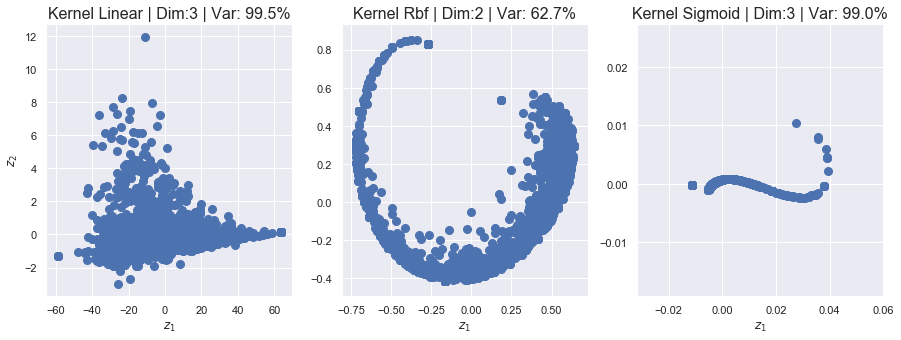

In [7]:
ratings_100k,rat_sparse = fill_na(rat_100k, "item", "mean")
PCA_Comps = plot_pca(ratings_100k, dim_list = (3,2,3)) 

OBS: O número de dimensões mostrado aqui é meramente ilustrativo, serão testadas diferentes valores no relatório a seguir e detalahados na seção de parâmetros.

Em seguida observamos que fazendo o mesmo estudo para observar a redução de dimensionalidade usando landmarks (com critério de filmes mais populares), nao tivemos um efeito satisfatório. No caso aqui ilustrado formam usadas apenas 3 dimensões para facilitar a visualização do gráfico pairplot, porém não houve melhora mesmo com 20 dimensões.

Número de Landmarks:  3


<Figure size 432x288 with 0 Axes>

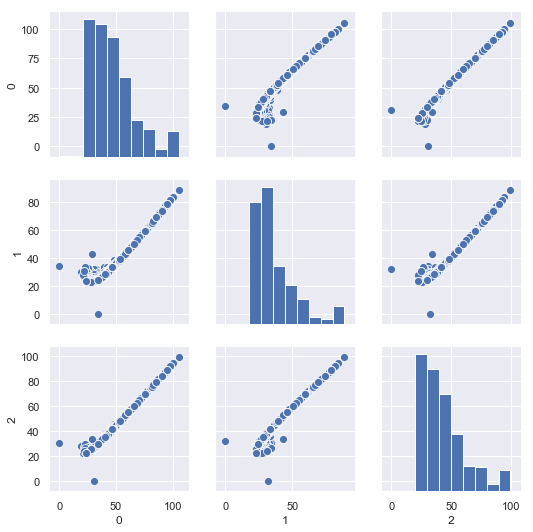

In [10]:
#viz subspace
def visualize_landmark(df):
    plt.figure(),
    g = sns.pairplot( df, x_vars=df.columns, y_vars=df.columns)
    plt.show()
    
X_filled, X_sparse = fill_na(rat_100k, "item", "mean")    
land = Similarity_Matrix(3).select(X_sparse, X_filled)
SM_Euc_100k= land.similarity(X_filled,"euclidean")
print("Número de Landmarks: ", 3)
visualize_landmark(SM_Euc_100k)

## Matriz de Similaridade

A seguir construímos a matriz de similaridade usando distância euclidiana e cosseno a partir da classe SImilarity_Matrix descrita abaixo.

In [9]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

class Similarity_Matrix:
    
    def __init__(self, N_landmarks):
        self.N_landmarks = N_landmarks
        
    
    def select(self, data, data_filled):
        self.data = data
        self.data_filled = data_filled
        
        #seleciona os N_landmarks usuários com mais filmes vistos
        UI_count = self.data.T.describe().T
        self.landmarks_id = UI_count['count'].sort_values(ascending=False).head(self.N_landmarks)
        self.landmarks_id = pd.DataFrame(self.landmarks_id).index.tolist()
        
        #seleciona os as colunas dos landmarks preenchidos
        self.UI_landmarks = self.data_filled.loc[self.landmarks_id]
        
        return self
    

    def similarity(self, data, metric): #Alg 2
        self.metric=metric
        self.data = data
        
        if self.metric == "cosine":
            return pd.DataFrame(cosine_similarity(X=self.data, Y=self.UI_landmarks))
        
        if self.metric == "euclidean":
            return pd.DataFrame(euclidean_distances(X=self.data, Y=self.UI_landmarks))
        

## Parâmetros do modelo

Na função abaixo vemos os parâmetros testados. A redução de dimensionalidade será feita com PCA e landmarks, com 15 (n_try) valores de componentes em escala logaritma entre 1 e 500, o número de vizinhos varia da mesma forma, mas entre 1 e 316 vizinhos (para um número maior de vizinhos o modelo nao apresentou melhoria, e um aumento exponencial no tempo computacional). Por fim havia também a opção de preencher os valores nulos com média e com zeros, sendo a segunda abandonada por nao apresentar bons resultados.

In [11]:
def get_parameters(model, n_try):
    
    
    if model=="PCA":
        k_neighboors_list = np.sort(np.array(list(set(np.rint(np.logspace(0, 2.1, n_try)))))) #1..316
        components_list = np.sort(np.array(list(set(np.rint(np.logspace(0, 2.6, n_try)))))) #1..500
        similarity_metrics = ["euclidean", "cosine"]
        fill_list = ["mean"]#, "zero",]
            
            
    if model=="Landmarks":        
        k_neighboors_list = np.sort(np.array(list(set(np.rint(np.logspace(0, 2.1, n_try)))))) #1..316
        components_list = np.sort(np.array(list(set(np.rint(np.logspace(0, 2.6, n_try)))))) #1..500
        similarity_metrics = ["euclidean", "cosine"]
        fill_list = ["mean"]#, "zero",]


    knn_parameters = {
        "k_neighboors_list": k_neighboors_list,
        "components_list": components_list,
        "similarity_metrics": similarity_metrics,
        "fill_list": fill_list
    }
    
    return knn_parameters


## Treinamento KNN e Função de Erro

A função predict_rating é responsável por calcular a matriz de notas preditas a através do regressor do algoritmo KNN encontrado na biblioteca scikit-learn. Já as medidade de erro MAE e RMSE são calculadas a partir da função get_error.

Obs: Durante a apresentação do relatório, o modelo apresentou valores muito baixos para o MAE (prox. 0.1), isso aconteceu devido a um erro na função que avaliava o erro, e jaá devidamente corrigidos para essa versão.

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from math import sqrt

def get_error(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()

    return mean_squared_error(pred, actual), math.sqrt(mean_squared_error(pred, actual))


    #KNN(SM_train, SM_test, y_train_filled, y_test_filled,metric, int(kn))
def predict_rating(X_train, X_test, y_train, y_test, y_test_sparse, metric, n_neighboors):
    
    knn = KNeighborsRegressor(n_neighboors, metric=metric)
    y_pred = knn.fit(X_train, y_train).predict(X_test)
    
    y_test_sparse[np.isnan(y_test_sparse)] = 0
    mae_test, mse_test = get_error(np.array(y_pred), np.array(y_test_sparse))
    

    return knn, mae_test, mse_test

__Disclaimer:__ Foi tentado criar uma funcão pra predizer as notas manualmente, porém o tempo de execução de cada modelo era muito longo, 30s com apenas 10 vizinhos (inialmente eram 8 minutos), contra 0.1s do scikit learn na mesma configuração, logo se tornou inviável gerar os resultados a partir desse modelo. De qualquer forma, para enriquecer o trabalho, a função predict_rating_manual, foi colocada logo abaixo.

In [13]:
   #predict_rating(SM_train, SM_test, y_train_filled, y_test_filled, y_train_sparse, y_test_sparse, kn)
def predict_rating_manual(X_train, X_test, y_train, y_test, y_train_sparse, y_test_sparse, k_neighboors):
    
    #start1 = time.time()

    X = X_test
    y = y_test
    
    y_sparse = y_test_sparse
    X.columns = y.index
    X.index = y.index
    

    pred_ratings = np.zeros((len(y_train.index)+len(y_test.index) , len(y_train.columns)))
    #print(pred_ratings.shape)
    users_mean = y.mean(1)
    pred = {}
    for user in y.index:
        
        
        #lista dos vizinhos (u') mais proximos de U
        K_viz_list = X[user].sort_values(ascending=False).index[1: 1+k_neighboors]
        
        
        #elementos da SM que vao ser usados
        S_uu = X[user][K_viz_list]
        sum_S_uu = sum(S_uu)
        

        #media do usuario
        u_bar = users_mean[user]
        uk = np.array([users_mean.loc[K_viz_list],]*len(y.columns)).T
        yt = y.loc[K_viz_list]
        
        #preenche a nota
        pred_ratings[user][y.columns] = (np.dot(S_uu, (yt[y.columns] - uk))/sum_S_uu) + u_bar
        
    #elapsed_time1 = time.time() - start1
    #print("ep1: ", elapsed_time1)
    
    pred_ratings = pd.DataFrame(pred_ratings)
    pred_ratings = pred_ratings.iloc[y.index]
    y_sparse[np.isnan(y_sparse)] = 0
    
    #print(pred_ratings.shape)
    #print(y_test.shape)
    
    mae, mse = get_error(np.array(pred_ratings), np.array(y_sparse))

    return mae, mse

A função abaixo é meramente auxiliar para facilitar a criação dos gráficos usando a média de cada fold.

In [14]:
def agg_kfold(df):
    columns=["fold", "fill_na", "Sim_Metric", "Components", "k_neighboors", "mae_test", "mse_test"]
    
    #Agregate mae
    aggdf=df.groupby(columns[1:5]).mae_test.agg(["mean"])
    mae_mean_fold = [i for i in aggdf['mean'][:]]
    df = df[df.fold == 1]
    df['mae_test']=mae_mean_fold
    
    #Agregate mse
    aggdf=df.groupby(columns[1:5]).mse_test.agg(["mean"])
    mse_mean_fold = [i for i in aggdf['mean'][:]]
    df = df[df.fold == 1]
    df['mse_test']=mse_mean_fold
    
    #Agregate time
    aggdf=df.groupby(columns[1:5]).elapsed_time.agg(["mean"])
    elapsed_time_fold = [i for i in aggdf['mean'][:]]
    df = df[df.fold == 1]
    df['elapsed_time']=elapsed_time_fold
    

    
    #atribute
    df = df.loc[:,["fill_na", "Sim_Metric","Components","k_neighboors", "mae_test", "mse_test", "elapsed_time"]]
    
    return df

## Grid Search dos parametros

A função abaixo é resposá por realizar o treinamento e teste do modelo usando 5-fold e seguindo todos os parâmetros desejados e por criar a tabela de resultados que irá gerar os gráficos a seguir

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def grid_search(X, model, kind, n_try):
    parameters = get_parameters(model, n_try)

    y = X
    result  = pd.DataFrame(
        columns=["fold", "fill_na", "Sim_Metric", "Components", "k_neighboors", "mae_test", "mse_test", "elapsed_time"])


    # K-Fold
    kf = KFold(n_splits=5, shuffle=True)
    
    fold, row = 0, -1
    X_filled, X_sparse = fill_na(X, kind, fill_type='zero') #to get split index
    
    
    #X_train_100k, X_test_100k = train_test_split( df_features_100k_filled_avg, test_size=0.2)
    for train_index, test_index in kf.split(X_filled):
        fold += 1
        
        
        for fill_type in parameters['fill_list']:
            
            X_filled, X_sparse = fill_na(X, kind, fill_type)
            y_filled, y_sparse = fill_na(y, kind, fill_type)
        
            # get train and test splits
            X_train_sparse, X_test_sparse = X_sparse.iloc[train_index], X_sparse.iloc[test_index]
            y_train_sparse, y_test_sparse = y_sparse.iloc[train_index], y_sparse.iloc[test_index]
            
            X_train_filled, X_test_filled = X_filled.iloc[train_index], X_filled.iloc[test_index]
            y_train_filled, y_test_filled = y_filled.iloc[train_index], y_filled.iloc[test_index]
            

            for metric in parameters['similarity_metrics']:
                for N_components in parameters['components_list']:
                    
                    
                    if model == "Landmarks":
                        # Landmark analysis 
                        landmarks = Similarity_Matrix(int(N_components)).select(X_train_sparse, X_train_filled)

                        # Similarity matrix
                        SM_train = landmarks.similarity(X_train_filled,metric)
                        SM_test = landmarks.similarity(X_test_filled,metric)
                        
                        
                    
                    if model == "PCA":
                        pca = PCA(n_components=int(N_components)).fit(X_train_filled)
                        SM_train = pca.transform(X_train_filled)
                        SM_test = pca.transform(X_test_filled)
                    

                    for kn in parameters['k_neighboors_list']:
                        start1 = time.time()

        
                        knn_regressor, mae_test, mse_test = predict_rating(
                                                        SM_train, SM_test, 
                                                        y_train_filled, y_test_filled, y_test_sparse ,
                                                        metric, int(kn))
                        elapsed_time = time.time() - start1
                        row +=1
                        result.loc[row]=[fold,fill_type,metric,N_components,kn,mae_test, mse_test, elapsed_time]
                        print(row, elapsed_time)
                        #limpar memoria
                        knn_regressor, mae_test, mse_test = None,None,None
                    
                    landmarks, SM_train, SM_test = None,None,None

                                
    #result = agg_kfold(result)
    return result

## Setup dos Modelos

A função abaixo é responsável por selecionar os dados (100k e 1M) e configurá-los parar serem usados item X item ou user x user, e por dizer qual a técnica de redução de dimensionalidade será usada, o nome dos 8 modelos está descrito pela variável model_name logo abaixo.

In [45]:
model_name = ["100k_item_Landmarks"
    ,"100k_item_PCA"
    ,"100k_user_Landmarks"
    ,"100k_user_PCA"
    ,"1M_item_Landmarks"
    ,"1M_item_PCA"
    ,"1M_user_Landmarks"
    ,"1M_user_PCA"]



def get_results(db_100k, db_1M, model_name, n_try):

    database_list = [db_1M]#[db_100k, db_1M]
    kind_list = ["item", "user"]
    model_list = ["Landmarks", "PCA"]
    

    
    results, ind_name = {},0
    for data in database_list:
 
        for kind in kind_list:
        
            for model in model_list:
                print(model_name[ind_name])
                results[model_name[ind_name]]=grid_search(data,model=model,kind=kind,n_try=n_try)
            
                #save to csv
                df = pd.DataFrame.from_dict(results[model_name[ind_name]])
                file_name = str(model_name[ind_name]+".csv")
                df.to_csv(file_name, index=False)
                ind_name+=1
                
                #break
            #break
        #break
    
    return results
        
n_try = 15   #lembrar de arrumar o kfold
results = get_results(rat_100k, rat_1M, model_name, n_try)

Obs: Devido ao espaço reduzido no hd da minha máquina (macbook), tive problemas de memória ao gerar os resultados do dataset de 1M, devido a essa limitação eles foram gerados separadamente e salvos em csv e depois carregados novamente na memória logo abaixo.

In [23]:
ind_name = 0 ##0..7
file_name = str("./resultados/" + model_name[ind_name]+".csv")
df =  pd.read_csv(str(file_name))  
print(model_name[ind_name])
df.head()

100k_item_Landmarks


,fill_na,Sim_Metric,Components,k_neighboors,mae_test,mse_test,elapsed_time
0,mean,euclidean,1.0,1.0,1.667089,1.242737,0.211768
1,mean,euclidean,1.0,2.0,1.386100,1.219749,0.192841
2,mean,euclidean,1.0,5.0,1.355634,1.196083,0.220962
3,mean,euclidean,1.0,12.0,1.357463,1.117470,0.249954
4,mean,euclidean,1.0,27.0,1.354665,1.147774,0.304046


Podemos visualizar no gráfico abaixo, que o algoritmo conververgiu rapidamente para valores de MAE próximos a 0.9e 1.1, tendo um aumento exponencial no tempo computacional

No handles with labels found to put in legend.


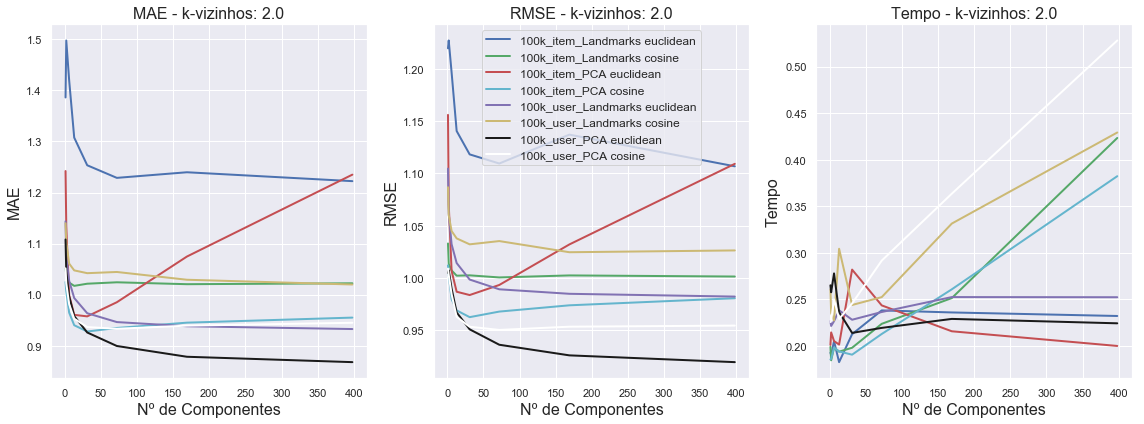

In [49]:
#gerar gráfico MAE/MSE vs Landmarks com K-Viz fixo
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.rcParams['figure.figsize'] = 16, 6
plt.rcParams['axes.labelsize'] = 16
#colors_list = ["blue","green","red","cyan","magenta","yellow","black","white"]
colors_list = ['b-','g-','r-','c-','m-','y-','k-','w-']
ind=-1

for ind_name in range(4):
    

    
    file_name = str("./resultados/" + model_name[ind_name]+".csv")
    df =  pd.read_csv(str(file_name))

    #df = pd.DataFrame.from_dict(results[model_name[m]])
    parameters = get_parameters("Landmarks", n_try) #nao generico
    for metric in parameters['similarity_metrics']:
        for fill_type in parameters['fill_list']:
            kn = parameters['k_neighboors_list']
            k_viz = kn[1]

            mae = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.k_neighboors ==k_viz)].mae_test
            mse = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.k_neighboors ==k_viz)].mse_test
            te=df.loc[(df.fill_na == fill_type)&(df.Sim_Metric==metric)&(df.k_neighboors ==k_viz)].elapsed_time
            components = parameters["components_list"]
            ind+=1

            plt.subplot(1,3,1)
            plt.title('MAE - k-vizinhos: '+ str(k_viz))
            plt.ylabel('MAE')
            plt.xlabel('Nº de Componentes')
            label = model_name[ind_name]+' '+ metric
            plt.plot(components,mae, colors_list[ind], label=label)
            #plt.legend()


            plt.subplot(1,3,2)
            plt.title('RMSE - k-vizinhos: '+ str(k_viz))
            plt.ylabel('RMSE')
            plt.xlabel('Nº de Componentes')
            plt.plot(components,mse, colors_list[ind], label=label)
            plt.legend()
            

            plt.subplot(1,3,3)
            plt.title('Tempo - k-vizinhos: '+ str(k_viz))
            plt.ylabel('Tempo')
            plt.xlabel('Nº de Componentes')
            plt.plot(components,te, colors_list[ind], label=label)
            #plt.legend()
            #break
        #break
        
plt.tight_layout()
plt.show()

Datatset 1M

No handles with labels found to put in legend.


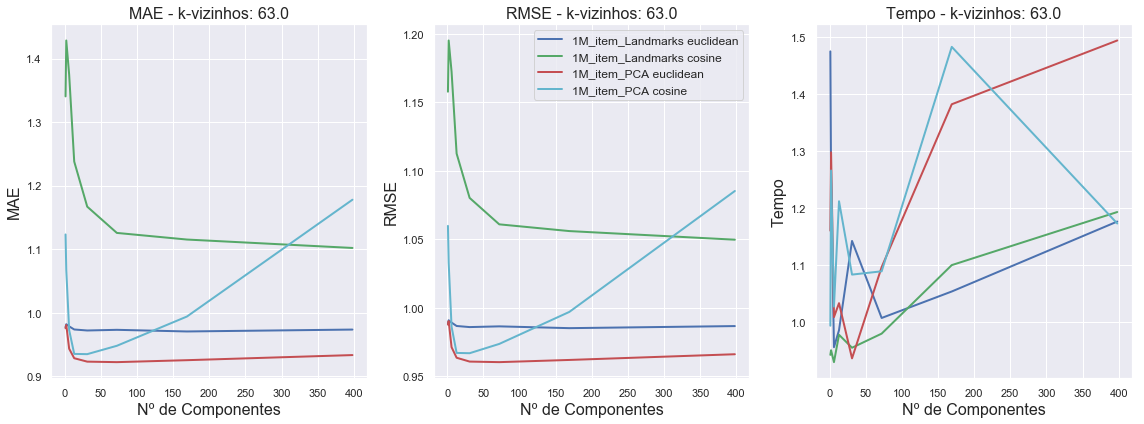

In [57]:
#gerar gráfico MAE/MSE vs Landmarks com K-Viz fixo
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.rcParams['figure.figsize'] = 16, 6
plt.rcParams['axes.labelsize'] = 16
#colors_list = ["blue","green","red","cyan","magenta","yellow","black","white"]
colors_list = ['b-','g-','r-','c-','m-','y-','k-','w-']
ind=-1

for ind_name in [4,5]:
    

    
    file_name = str("./resultados/" + model_name[ind_name]+".csv")
    df =  pd.read_csv(str(file_name))

    #df = pd.DataFrame.from_dict(results[model_name[m]])
    parameters = get_parameters("Landmarks", n_try) #nao generico
    for metric in parameters['similarity_metrics']:
        for fill_type in parameters['fill_list']:
            kn = parameters['k_neighboors_list']
            k_viz = kn[1]

            mae = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.k_neighboors ==k_viz)].mae_test
            mse = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.k_neighboors ==k_viz)].mse_test
            te=df.loc[(df.fill_na == fill_type)&(df.Sim_Metric==metric)&(df.k_neighboors ==k_viz)].elapsed_time
            components = parameters["components_list"]
            ind+=1

            plt.subplot(1,3,1)
            plt.title('MAE - k-vizinhos: '+ str(kn[6]))
            plt.ylabel('MAE')
            plt.xlabel('Nº de Componentes')
            label = model_name[ind_name]+' '+ metric
            plt.plot(components,mae, colors_list[ind], label=label)
            #plt.legend()


            plt.subplot(1,3,2)
            plt.title('RMSE - k-vizinhos: '+ str(kn[6]))
            plt.ylabel('RMSE')
            plt.xlabel('Nº de Componentes')
            plt.plot(components,mse, colors_list[ind], label=label)
            plt.legend()
            

            plt.subplot(1,3,3)
            plt.title('Tempo - k-vizinhos: '+ str(kn[6]))
            plt.ylabel('Tempo')
            plt.xlabel('Nº de Componentes')
            plt.plot(components,te, colors_list[ind], label=label)
            #plt.legend()
            #break
        #break
        
plt.tight_layout()
plt.show()

Dessa vez fizemos a mesma análise para o MAE e MSE com numero de componentes fixo e o numero de k-vizinhos variando.

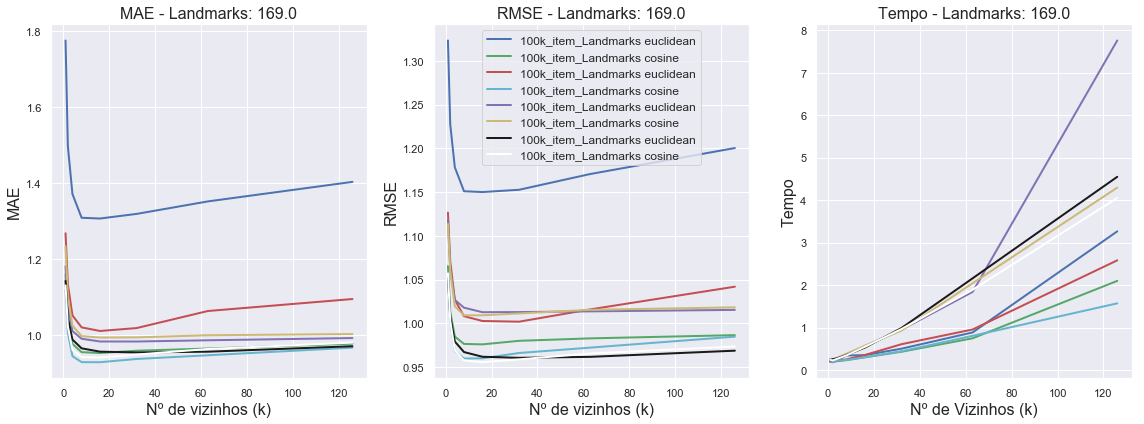

In [59]:
#gerar gráfico MAE/MSE vs Kviz com land fixo
ind=-1
for ind_name in range(4):
    #print(model_name[m])
    
    file_name = str("./resultados/" + model_name[ind_name]+".csv")
    df =  pd.read_csv(str(file_name))
    
    parameters = get_parameters("Landmarks", n_try) #nao generico
    for metric in parameters['similarity_metrics']:
        for fill_type in parameters['fill_list']:
            comp = parameters['components_list']
            cp=comp[1]

            mae = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.Components == cp)].mae_test
            mse = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.Components == cp)].mse_test
            te=df.loc[(df.fill_na == fill_type)&(df.Sim_Metric==metric)&(df.Components ==cp)].elapsed_time
            k_vizinhos = parameters['k_neighboors_list']
            ind+=1
             
            cp=comp[6]
            plt.subplot(1,3,1)
            plt.title('MAE - Landmarks: '+ str(cp))
            plt.ylabel('MAE')
            plt.xlabel('Nº de vizinhos (k)')
            label = model_name[m]+' '+ metric
            plt.plot(k_vizinhos, mae, colors_list[ind])#, label=label)
            #plt.legend()

            
            plt.subplot(1,3,2)
            plt.title('RMSE - Landmarks: '+ str(cp))
            plt.ylabel('RMSE')
            plt.xlabel('Nº de vizinhos (k)')
            plt.plot(k_vizinhos, mse, colors_list[ind], label=label)
            plt.legend()
            
            
            plt.subplot(1,3,3)
            plt.title('Tempo - Landmarks: '+ str(cp))
            plt.ylabel('Tempo')
            plt.xlabel('Nº de Vizinhos (k)')
            plt.plot(k_vizinhos,te, colors_list[ind], label=label)
            #plt.legend()
        
plt.tight_layout()
plt.show()

Dataset 1M

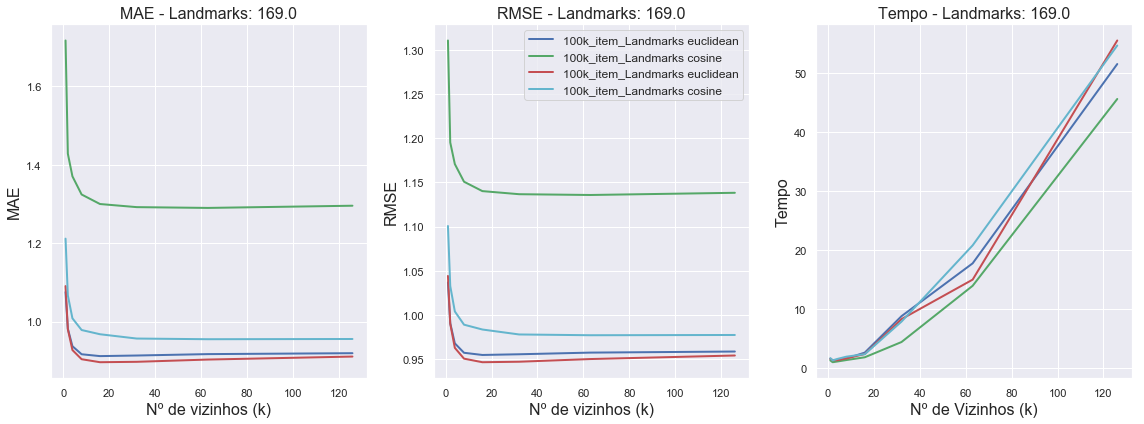

In [60]:
#gerar gráfico MAE/MSE vs Kviz com land fixo
ind=-1
for ind_name in [4,5]:
    #print(model_name[m])
    
    file_name = str("./resultados/" + model_name[ind_name]+".csv")
    df =  pd.read_csv(str(file_name))
    
    parameters = get_parameters("Landmarks", n_try) #nao generico
    for metric in parameters['similarity_metrics']:
        for fill_type in parameters['fill_list']:
            comp = parameters['components_list']
            cp=comp[1]

            mae = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.Components == cp)].mae_test
            mse = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.Components == cp)].mse_test
            te=df.loc[(df.fill_na == fill_type)&(df.Sim_Metric==metric)&(df.Components ==cp)].elapsed_time
            k_vizinhos = parameters['k_neighboors_list']
            ind+=1
             
            cp=comp[6]
            plt.subplot(1,3,1)
            plt.title('MAE - Landmarks: '+ str(cp))
            plt.ylabel('MAE')
            plt.xlabel('Nº de vizinhos (k)')
            label = model_name[m]+' '+ metric
            plt.plot(k_vizinhos, mae, colors_list[ind])#, label=label)
            #plt.legend()

            
            plt.subplot(1,3,2)
            plt.title('RMSE - Landmarks: '+ str(cp))
            plt.ylabel('RMSE')
            plt.xlabel('Nº de vizinhos (k)')
            plt.plot(k_vizinhos, mse, colors_list[ind], label=label)
            plt.legend()
            
            
            plt.subplot(1,3,3)
            plt.title('Tempo - Landmarks: '+ str(cp))
            plt.ylabel('Tempo')
            plt.xlabel('Nº de Vizinhos (k)')
            plt.plot(k_vizinhos,te, colors_list[ind], label=label)
            #plt.legend()
        
plt.tight_layout()
plt.show()